In [95]:
import pandas as pd
import numpy as np
import warnings
import six
import matplotlib.pyplot as plt
import scipy.optimize as sco 
warnings.filterwarnings('ignore')

In [81]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


In [2]:
data = {}
data['macro'] = pd.read_csv('sy_macro.csv')
data['price'] = pd.read_csv('sy_price.csv' )

for i in list(data.keys()):
    data[i] = data[i].iloc[2:]
    data[i].set_index('ticker', inplace = True)
    data[i].index.name = 'asofdate'
    data[i].index = pd.to_datetime(data[i].index)
    data[i] = data[i].astype(float )
    data[i + '_m'] = data[i].resample('M').last()
data['price_m_rts'] =( data['price_m']/data['price_m'].shift(1) -1)

In [3]:
data['price_d_rts'] = (data['price']/ data['price'].shift(1)-1)

In [4]:
data['price_m_rts'].head()

,LF98TRUU Index,SPX Index,NG1 COMB Comdty,CCMP Index,XAU Curncy,CL1 COMB Comdty,HG1 COMB Comdty,INDU Index,SXXP Index,SHCOMP Index,LBUSTRUU Index
asofdate,,,,,,,,,,,
1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-07-31,NaN,0.008479,NaN,NaN,0.0,NaN,NaN,0.000956,NaN,NaN,NaN
1950-08-31,NaN,0.032511,NaN,NaN,0.0,NaN,NaN,0.035834,NaN,NaN,NaN
1950-09-30,NaN,0.055917,NaN,NaN,0.0,NaN,NaN,0.043819,NaN,NaN,NaN
1950-10-31,NaN,0.004113,NaN,NaN,0.0,NaN,NaN,-0.005745,NaN,NaN,NaN


In [225]:
allocation_tuple = (('100spx', {'SPX Index':1} ), 
                    ('100nasdaq',{'CCMP Index':1}),
                    ('60nasdaq20hy20ig',{'CCMP Index':0.6,'LBUSTRUU Index':0.2, 'LF98TRUU Index':0.2}),
                    ('40spx30nasdaq30dow',{'SPX Index':0.4,'CCMP Index':0.3,'INDU Index':0.3}),
                    ('60spx40ig',{'SPX Index':0.6, 'LBUSTRUU Index':0.4}),
                    ('60spx40hy',{'SPX Index':0.6, 'LF98TRUU Index':0.4}),
                   (('25spx25ig25copper25gold'),{'SPX Index':0.25, 'LBUSTRUU Index':0.25, 'HG1 COMB Comdty':0.25,'XAU Curncy':0.25}))
allocation_strategy = {}
for x in allocation_tuple: 
    allocation_strategy[x[0]] = x[1]

In [226]:
# generate portfolio in annnual terms
def portfolio_stats(returns, weights, rf): 
    """This function calculates portfolio aggregated returns, volatility and sharpe
    returns:  a dataframe with different asset daily returns
    weight: a matrix allocating weights
    rf : risk free interest rate
    portfolio_stats(data['price_d_rts'][['SPX Index','CCMP Index']].loc['2015-01-01':'2020-01-01'], [0.6,0.4], 0.02)"""
    returns.dropna(inplace  =True)
    #sum(weights * returns)
    #total_returns =( (returns+1 ).cumprod() * weights).sum(axis= 1 )
    mean_returns = ((weights * returns.mean()).sum()) *260
    #portfolio_std = W * covariance matrix of returns * W.transpose()
    weights = np.asmatrix(weights)
    sigma = np.sqrt( weights * np.asmatrix(np.cov(returns.T)) * weights.T)  * np.sqrt(260)
    sharpe = (mean_returns - rf)/float(sigma)
    return mean_returns, float(sigma), sharpe


def calculate_allocation_returns(inception_date,end_date, allocation_strategy, rf ): 
    """this function takes in a list of asset allocation and returns cumulative returns
    inception_date: start date
    end_date: stop date
    allocation strategy: dictionary object, contains allocation dictionary"""
    allocation_rts = pd.DataFrame()
    portfolio_stats_df = pd.DataFrame( columns = ['ann_mean_rts','vol','sharpe'])
    for i in allocation_strategy.keys(): 
        tkrs = list(allocation_strategy[i].keys())
        weights = list(allocation_strategy[i].values())
        
        subdf = data['price_m_rts'].loc[inception_date:end_date][tkrs]
        subdf_cum_rts = (subdf+1).cumprod()
        allocation_rts[i] = ( (subdf_cum_rts* weights ).sum(axis = 1))
        
        #calculate portfolio stats
        portfolio_stats_df.loc[i] = (list(portfolio_stats(data['price_d_rts'][tkrs].loc[inception_date:end_date].dropna(), weights, rf)))
        portfolio_stats_df = portfolio_stats_df.dropna(axis = 0).sort_values(by = 'ann_mean_rts')
    return allocation_rts,portfolio_stats_df

### How did different asset allocation strategy perform in history ? 

In [268]:
def show_allocation_graph(start_date, end_date, allocation_strategy, rf): 
    test = calculate_allocation_returns(start_date,end_date, allocation_strategy, 0.02)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    test[0].dropna().plot(ax = axes [0],title ='Allocation returns since:' + start_date + ','+end_date)
    render_mpl_table(test[1].apply(lambda x : round(x,2) ).reset_index() ,ax = axes [1], header_columns=0, col_width=2.2)
    

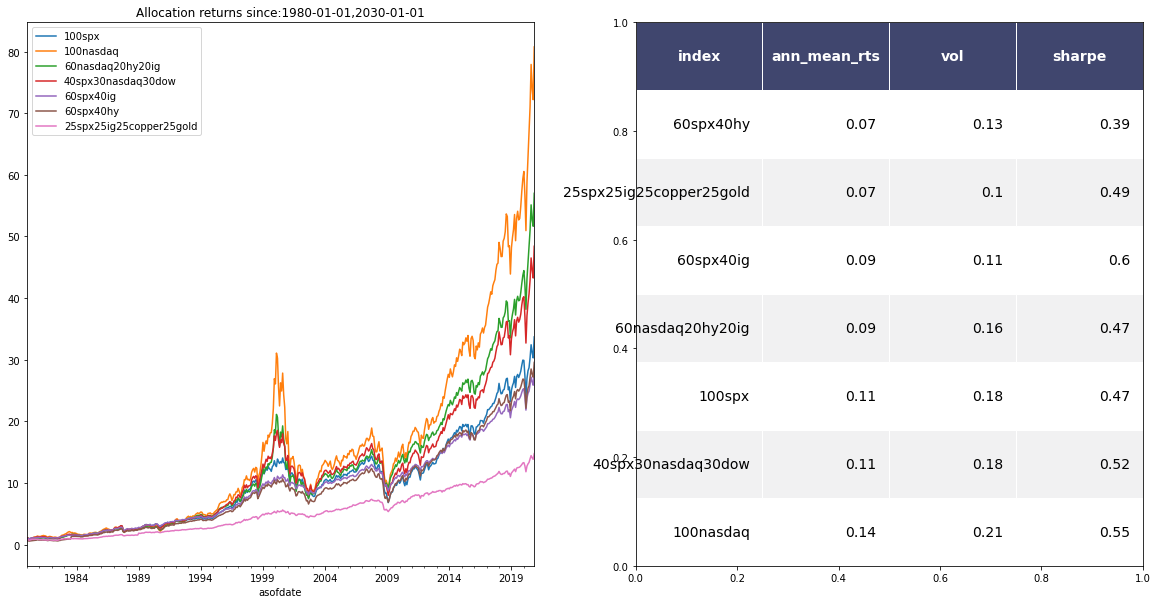

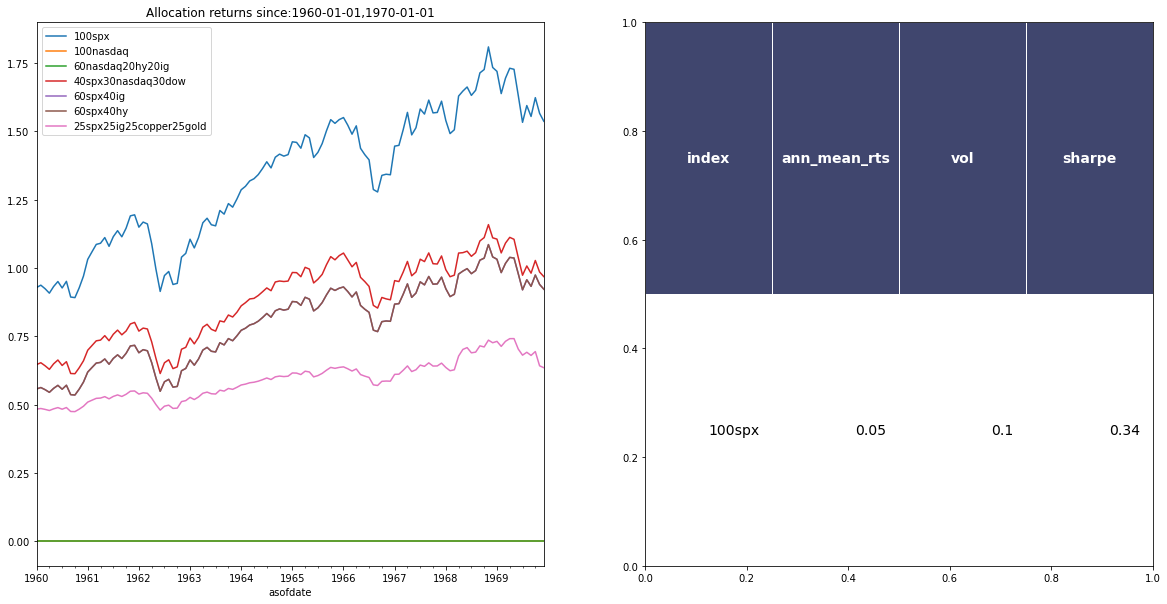

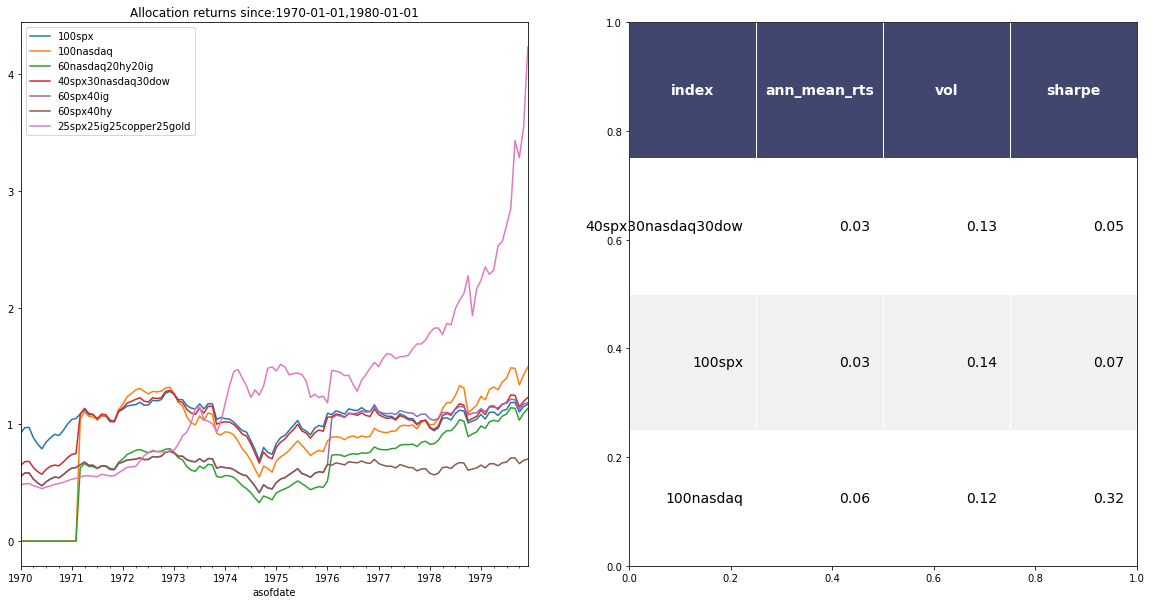

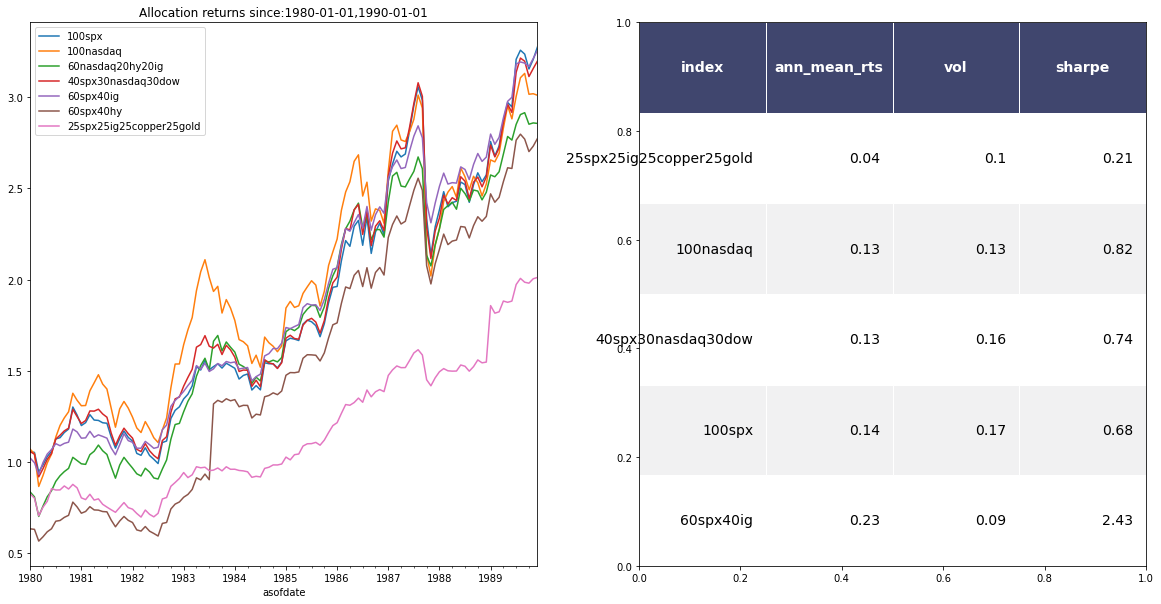

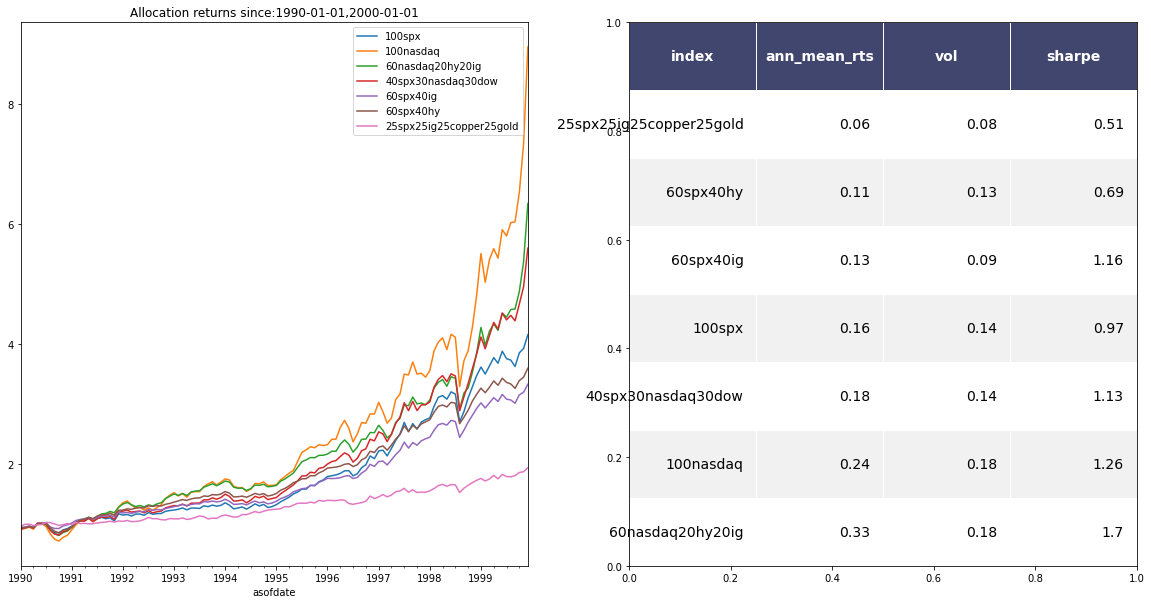

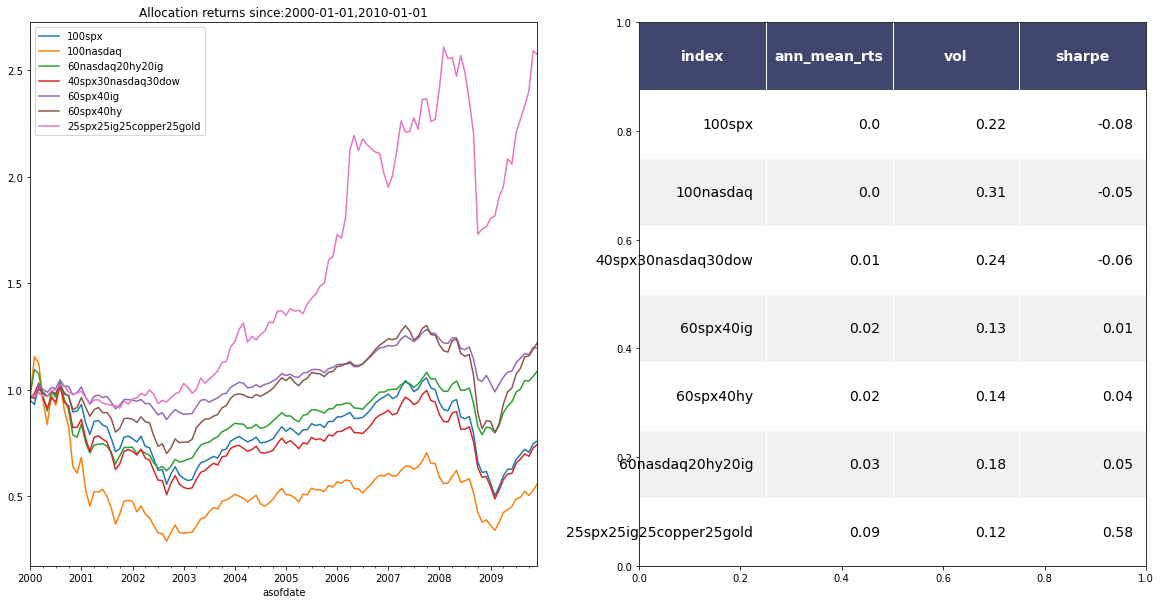

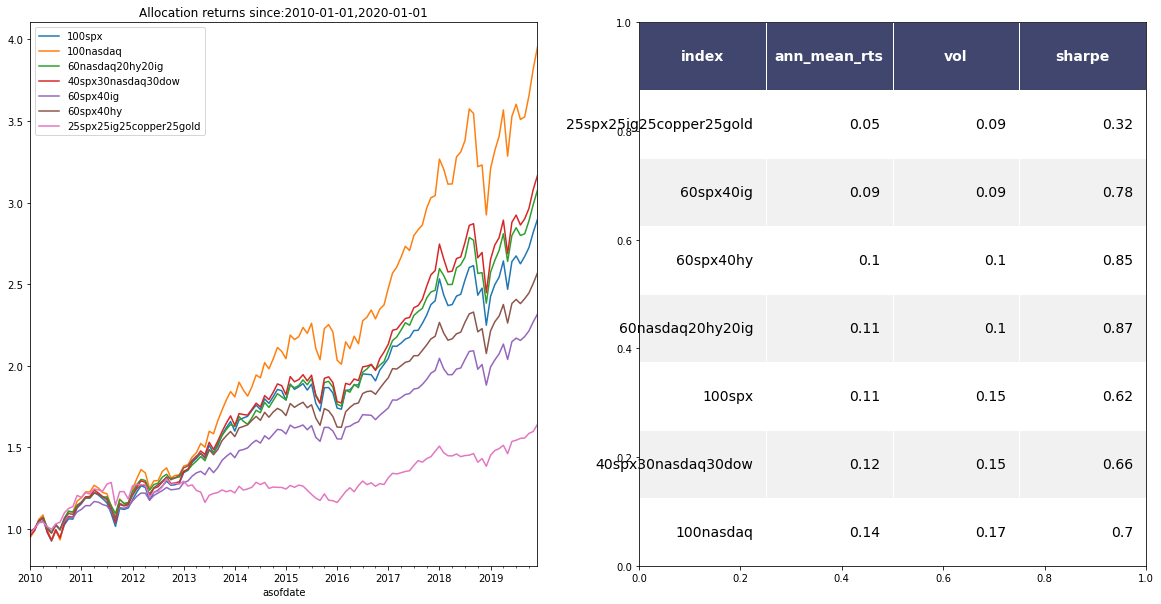

In [228]:
dates = [('1980-01-01','2030-01-01'),('1960-01-01','1970-01-01'),('1970-01-01','1980-01-01'), ('1980-01-01','1990-01-01'),('1990-01-01','2000-01-01'),('2000-01-01','2010-01-01'),('2010-01-01','2020-01-01')]
for i in dates: 
    show_allocation_graph(i[0], i[1], allocation_strategy, 0.02)
#     test = calculate_allocation_returns(i[0],i[1], allocation_strategy, 0.02)
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#     test[0].dropna().plot(ax = axes [0],title ='Allocation returns since:' + i[0] + ','+i[1])
#     render_mpl_table(test[1].apply(lambda x : round(x,2) ).reset_index() ,ax = axes [1], header_columns=0, col_width=2.2)
    

# Mean Variance optimization

In [243]:
def neg_sharpe_ratio(weights,returns, risk_free_rate):
    "define the cost function -- negative sharpe"
    return -portfolio_stats(returns, weights,risk_free_rate)[2]

def neg_returns(weights,returns, risk_free_rate):
    return -portfolio_stats(returns, weights,risk_free_rate)[0]

def total_returns(weights,returns, risk_free_rate):
    return - ((returns+1).cumprod() * weights).sum(axis= 1)[-1]

In [260]:
 """This function optimize asset allocation weights,
 returns: assets daily returns dataframe
 rf: risk free rate
 cost_function: can choose to optimize on 'mean_returns' or 'sharpe' or 'total_returns'  """
def weight_optimizer(returns, rf, cost_function):

    n_assets = len(returns.columns)
    args = (returns, rf)
    bound = (0,1)
    bounds = tuple(bound for asset in range(n_assets))
    if cost_function == 'sharpe': 
        print('objective function: sharpe')
        result = sco.minimize(neg_sharpe_ratio, n_assets*[1./n_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))
    elif cost_function =='mean_returns':
        print('objective function: mean_returns')
        result = sco.minimize(neg_returns, n_assets*[1./n_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))
    elif cost_function =='total_returns':
        print('objective function:total_returns')
        result = sco.minimize(total_returns, n_assets*[1./n_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=({'type':'eq','fun':lambda x: np.sum (x)-1}))    
    final_weights = round(pd.DataFrame(result['x'], index = returns.columns ) .T,2)
    #portfolio_sharpe = -neg_sharpe_ratio(weights, returns, rf)
    mean_returns,sigma,sharpe = portfolio_stats(returns, result['x'], rf)
    weight_dict = dict(zip(final_weights.columns, final_weights.iloc[0]))
    total_rts =  ((returns+1).cumprod() *list (weight_dict.values())).sum(axis= 1)[-1]
    #print('returns:', mean_returns)
    return weight_dict,mean_returns,sharpe,total_rts

In [314]:
price_test = data['price_d_rts'][['SPX Index','CCMP Index','LF98TRUU Index','XAU Curncy','LBUSTRUU Index','SHCOMP Index']].dropna().loc['1980-01-01':'2020-06-01']
print(weight_optimizer(price_test, 0.02, 'total_returns'))
print(weight_optimizer(price_test, 0.02, 'sharpe'))


objective function:total_returns
({'SPX Index': 0.0, 'CCMP Index': 1.0, 'LF98TRUU Index': 0.0, 'XAU Curncy': 0.0, 'LBUSTRUU Index': 0.0, 'SHCOMP Index': 0.0}, 0.1113377162199014, 0.3529573647838588, 4.138859553153531)
objective function: sharpe
({'SPX Index': 0.0, 'CCMP Index': 0.04, 'LF98TRUU Index': 0.27, 'XAU Curncy': 0.03, 'LBUSTRUU Index': 0.65, 'SHCOMP Index': 0.01}, 0.06111782704050217, 1.2912727567612032, 2.8991808268336827)


objective function:total_returns
objective function: sharpe


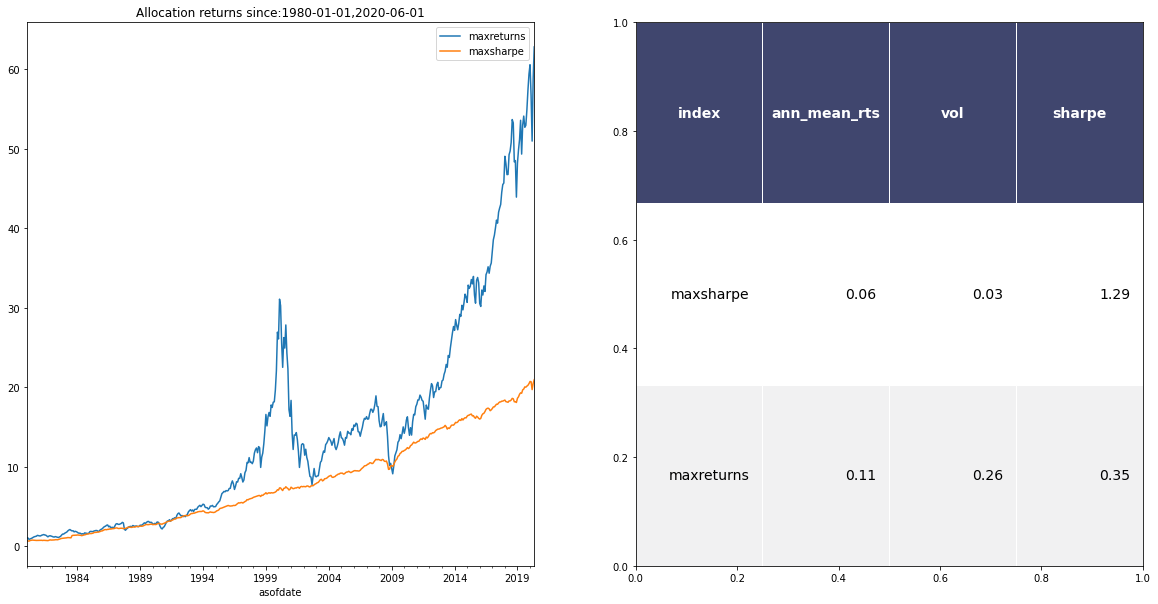

In [316]:
show_allocation_graph('1980-01-01', '2020-06-01',
                      {'maxreturns': weight_optimizer(price_test, 0.02, 'total_returns')[0],
                     'maxsharpe': weight_optimizer(price_test, 0.02, 'sharpe')[0]
                                                  }  , 0.02)

# Asset allocation strategy

In [ ]:
""" we assign a training window, and an allocation window,
training window is used to generate weights
allocation window is applied with the trained weights"""


